In [1]:
import os
import sys
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [16, 9]
import seaborn as sns
sns.set_style("whitegrid")

sys.path.append("../../pyelftools")             # relative location of pyelftools repo cloned from github
from elftools.elf.elffile import ELFFile
from tqdm import tqdm
from scipy import stats
from collections import Counter

In [2]:
path = "powerpc/"
files = os.listdir(path)
len(files)

7263

In [3]:
np.random.seed(1)
sample_files = np.random.choice(files, size=1000, replace=False)

In [4]:
def extract_code(path, file_list, min_file_size=10000, n_files=100):
    
    code_dict = {}
    counter = 0
    
    for file in file_list:
        with open(path + file, "rb") as f:
            try:
                elffile = ELFFile(f)
            except:
                continue
        
            try:
                text_section_header = elffile.get_section_by_name(".text").header
            except:
                continue
            offset = text_section_header.sh_offset
            size = text_section_header.sh_size
        
            if size >= min_file_size: # minimum size cutoff: 10kb of machine code
                counter += 1
                f.seek(offset)
                code_dict[file] = list(f.read(size))
                if counter == n_files: # number of files to select samples from
                    break
            else:
                continue
                
    return code_dict

In [5]:
sample_code_dict = extract_code(path, sample_files)

In [6]:
len(sample_code_dict.keys())

100

In [7]:
for file, code in sample_code_dict.items():
    print("%s\t%s\t%s" %(file, str(len(code)), code[:10]))

ae349a5f5608e261ed1f7cf0ffb94f2e	751264	[148, 33, 255, 224, 124, 8, 2, 166, 66, 159]
bca7e2c84cd099c1b83801d7cf1faa9e	12832	[148, 33, 255, 96, 124, 8, 2, 166, 66, 159]
981a4f1acc37798aec65713df6035ed4	166192	[148, 33, 255, 240, 124, 8, 2, 166, 66, 159]
e31ec4a734b788eed7157c45b823e41e	13776	[148, 33, 255, 32, 124, 8, 2, 166, 66, 159]
8caa1203c1f7403f09454d4c08e4bf87	11648	[148, 33, 251, 208, 124, 8, 2, 166, 66, 159]
2b91e76cf3651365fab0e774dbcfdcc7	109552	[148, 33, 255, 208, 124, 8, 2, 166, 66, 159]
00c5d5c39d64cd6bc224c0ef4f0e59f4	48112	[148, 33, 252, 208, 57, 32, 0, 0, 125, 128]
ea94bcc0dc5adfa6d7497ba65049de66	11520	[60, 0, 255, 254, 124, 44, 11, 120, 96, 0]
d519ac2d7f72d9d7c089e9d209a6cd3f	14128	[148, 33, 255, 160, 124, 8, 2, 166, 66, 159]
7e1a3910c4aea8394fc7ede0d8059282	12896	[148, 33, 255, 112, 124, 8, 2, 166, 66, 159]
4254bab4a64525e05248f474e3c4351a	31136	[148, 33, 239, 208, 124, 8, 2, 166, 66, 159]
a813841468e71691cde41726c7da187f	16080	[148, 33, 255, 160, 124, 8, 2, 166, 66,

In [8]:
def plot_dists(dictionary):
    for file, code in dictionary.items():
        sns.distplot(code, 
                     bins = 256,
                     kde=False,
                     hist_kws={'histtype':'step', 'cumulative': True, 'linewidth':1, 'alpha':0.1}, 
                     kde_kws={'cumulative': True},
                     norm_hist=True,
                     color="blue")
    plt.show()

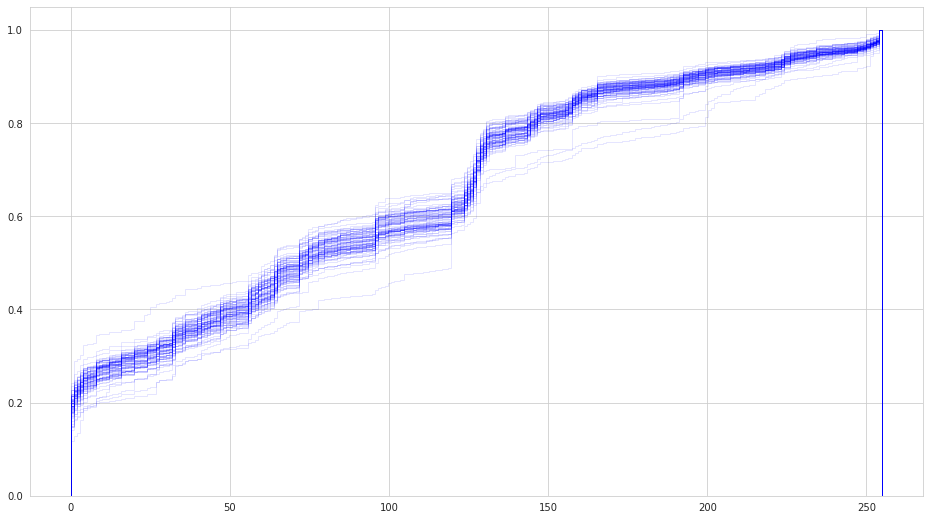

In [9]:
plot_dists(sample_code_dict)

In [10]:
def plot_sample(sample):
    sns.distplot(sample,
                 norm_hist=True,     
                 kde=False,
                 hist_kws={'histtype':'step', 'cumulative': True, 'linewidth':0.1, 'alpha':0.1},
                 kde_kws={'cumulative': True},  # want CDF
                 bins=256,                      
                 color="blue")

def create_code_samples(sample_size, n_rows, sample_source, plot=False):
    
    samples_df = pd.DataFrame(index=np.arange(0, n_rows), columns=[i for i in range(sample_size)])
    
    for i in tqdm(np.arange(0, n_rows)):
        sample = np.random.choice(sample_source, size=sample_size, replace=True)
        samples_df.loc[i] = sorted(sample)
        
    samples_mean = samples_df.mean(axis = 0)
    
    if plot is True:
        sns.distplot(samples_mean, norm_hist=True, kde=False, hist_kws={'histtype':'step', 'cumulative': True, 'linewidth':1, 'alpha':1},kde_kws={'cumulative': True},bins=256,color="red")
        plt.show()    
    
    return samples_mean

In [11]:
def create_reference_distribution(code_dictionary, sample_size, n_samples):
    # create data frame to hold mean sample of each file's code
    means_df = pd.DataFrame(index=list(code_dictionary.keys()),
                            columns=[i for i in range(sample_size)])
    
    # for each file's code, store mean of the samples in data frame
    for file, code in code_dictionary.items():
        means_df.loc[file] = create_code_samples(sample_size,
                                                 n_samples,
                                                 code)
    # average all samples means together
    mean = means_df.mean(axis = 0)
    median = means_df.median(axis = 0)
    return mean, median

In [12]:
mean, median = create_reference_distribution(sample_code_dict, 1000, 1000)

100%|██████████| 1000/1000 [00:38<00:00, 25.71it/s]


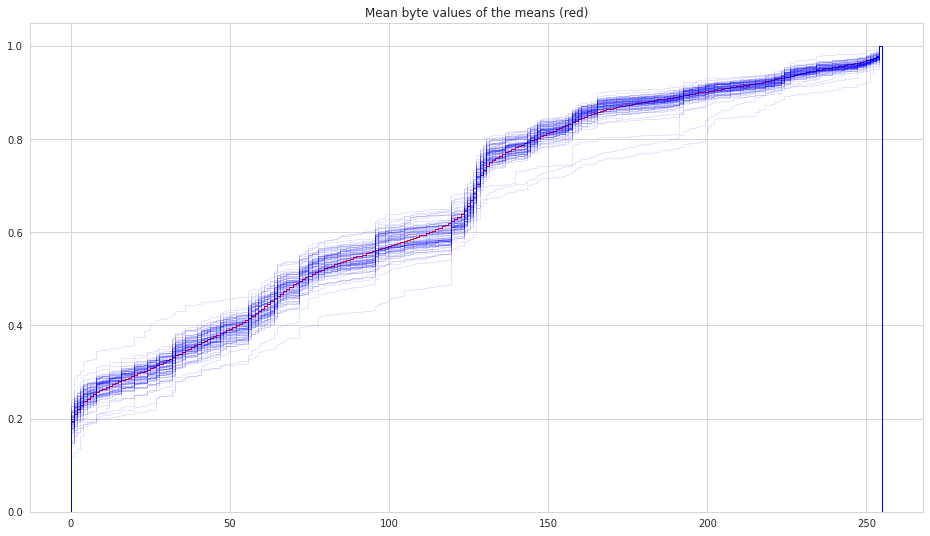

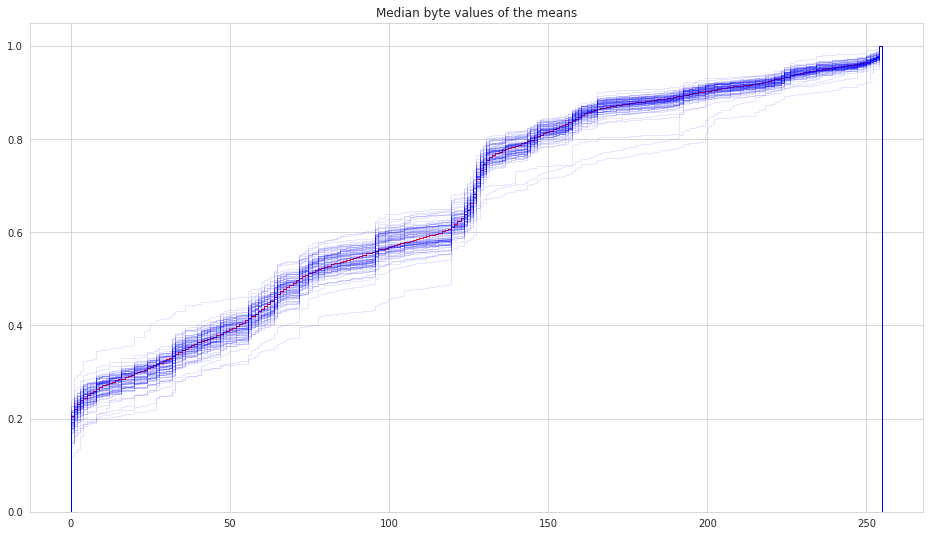

In [13]:
sns.distplot(mean, bins = 256, kde=False, hist_kws={'histtype':'step', 'cumulative': True, 'linewidth':1, 'alpha':1}, kde_kws={'cumulative': True}, norm_hist=True, color="red")

plt.title("Mean byte values of the means (red)")
plot_dists(sample_code_dict)


sns.distplot(median, bins = 256, kde=False, hist_kws={'histtype':'step', 'cumulative': True, 'linewidth':1, 'alpha':1}, kde_kws={'cumulative': True}, norm_hist=True, color="red")

plt.title("Median byte values of the means")
plot_dists(sample_code_dict)

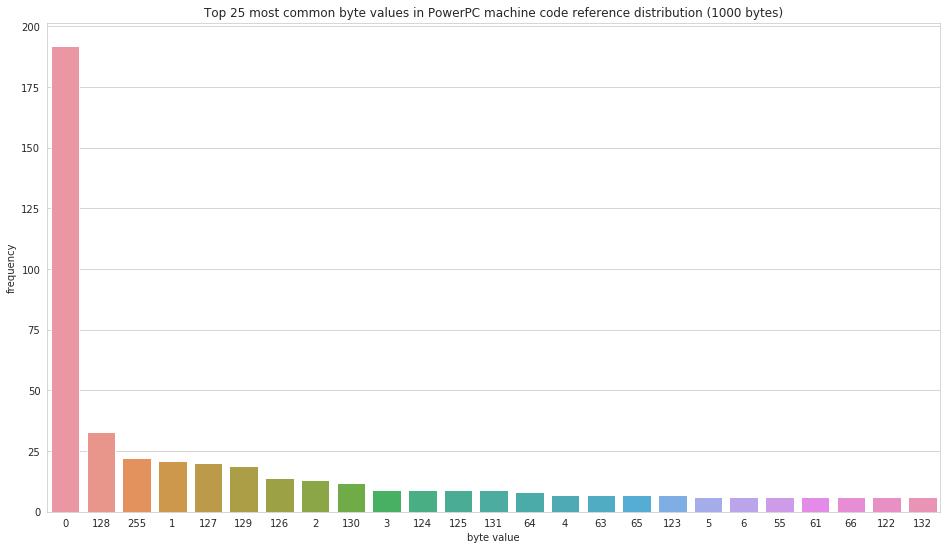

In [14]:
rounded_medians = [round(i) for i in median]
sorted_counts = sorted(Counter(rounded_medians).items(), key = lambda x: x[1], reverse=True)

counts_df = pd.DataFrame(sorted_counts[:25])
counts_df = counts_df.rename(columns={0:"byte value", 1:"frequency"})

sns.barplot(x="byte value", y="frequency", data=counts_df, order=counts_df["byte value"])
plt.title("Top 25 most common byte values in PowerPC machine code reference distribution (1000 bytes)")
plt.show()

In [15]:
[hex(i) for i in list(dict(sorted_counts).keys())[:25]]

['0x0',
 '0x80',
 '0xff',
 '0x1',
 '0x7f',
 '0x81',
 '0x7e',
 '0x2',
 '0x82',
 '0x3',
 '0x7c',
 '0x7d',
 '0x83',
 '0x40',
 '0x4',
 '0x3f',
 '0x41',
 '0x7b',
 '0x5',
 '0x6',
 '0x37',
 '0x3d',
 '0x42',
 '0x7a',
 '0x84']

In [16]:
# get pool of test files
test_pool = [file for file in files if file not in sample_files]

# select test files
np.random.seed(1)
test_files = np.random.choice(test_pool, size=3000, replace=False)

In [32]:
len(test_files)

3000

In [17]:
# check for overlap between files that the reference distribution was built from and the files used for testing
list(set(sample_code_dict.keys()) & set(test_files))

[]

In [29]:
test_code_dict = extract_code(path, test_files, n_files=3000)

In [30]:
for file, code in test_code_dict.items():
    print("%s\t%s\t%s" % (file, str(len(code)), code[:10]))

924c20997190e9d3e313a9b285baf179	52512	[148, 33, 255, 224, 124, 8, 2, 166, 66, 159]
0c752b6d1a4a2459950893fbf8c8144e	1677136	[148, 33, 255, 224, 124, 8, 2, 166, 66, 159]
c9031d21b815fc4c2ee6abb686e87640	134656	[148, 33, 255, 192, 124, 8, 2, 166, 66, 159]
a28434c2610bf290f4ee789e271e1ee1	13440	[148, 33, 255, 224, 124, 8, 2, 166, 66, 159]
37515392c15cdddae267e622f13d9d71	31296	[148, 33, 255, 80, 124, 8, 2, 166, 66, 159]
9ccbf17017ac99abccd7599ce160813d	3212416	[148, 33, 255, 224, 124, 8, 2, 166, 66, 159]
f0ec4b8d0c7e508aeb8fc149f15c845c	90800	[148, 33, 234, 192, 124, 8, 2, 166, 66, 159]
2eac320779a25ec9fda5458a959d7828	499168	[148, 33, 255, 224, 124, 8, 2, 166, 66, 159]
d0f9555218576820576af521a8d8f0f4	2312016	[148, 33, 255, 224, 124, 8, 2, 166, 66, 159]
6aa43e60d8b28c665664f466046787ce	95344	[148, 33, 253, 128, 124, 8, 2, 166, 66, 159]
3b48df60a84b0ab96e5346a613d6a5f5	1309360	[148, 33, 255, 240, 124, 8, 2, 166, 66, 159]
d843ef1118fd69058531e64580a70c00	12256	[148, 33, 255, 160, 124, 8, 

In [31]:
len(test_code_dict.keys())

605

In [20]:
test_results_df = pd.DataFrame(index=test_code_dict.keys(),
                               columns=["size", "wasserstein distance","energy distance", "mean", "median", "standard deviation"])

for file, code in test_code_dict.items():
    test_results_df.loc[file]["size"] = len(code)
    test_results_df.loc[file]["wasserstein distance"] = stats.wasserstein_distance(median, code)
    test_results_df.loc[file]["energy distance"] = stats.energy_distance(median, code)
    test_results_df.loc[file]["mean"] = np.mean(code)
    test_results_df.loc[file]["median"] = np.median(code)
    test_results_df.loc[file]["standard deviation"] = np.std(code)
    
print(test_results_df.shape)
test_results_df

(605, 6)


,size,wasserstein distance,energy distance,mean,median,standard deviation
924c20997190e9d3e313a9b285baf179,52512,2.6821,0.302951,83.5375,67,75.7545
0c752b6d1a4a2459950893fbf8c8144e,1677136,7.86999,0.803786,78.9426,66,67.718
c9031d21b815fc4c2ee6abb686e87640,134656,5.09478,0.50393,90.7825,76,79.1002
a28434c2610bf290f4ee789e271e1ee1,13440,3.003,0.306457,83.0138,72,74.1887
37515392c15cdddae267e622f13d9d71,31296,11.1406,1.14964,97.0042,88,83.9993
...,...,...,...,...,...,...
7437cca87618b7eaeac1d4ec48439f3b,11920,9.75533,0.933404,76.1263,62,69.2283
b170d622f52ed73b472f4e186dbf45e2,17744,4.33347,0.432406,81.5517,66,74.5544
eb7e4868a3e6a714ba989f5f2b92f8be,326720,1.99198,0.225164,87.5449,72,76.059
585d70e02d18782c545d071897a44b1c,19264,2.25866,0.263322,84.0306,70,75.8567


In [21]:
test_results_df.mean()

size                    385479.735537
wasserstein distance         3.967288
energy distance              0.419528
mean                        85.405114
median                      72.142149
standard deviation          75.287018
dtype: float64

In [22]:
test_results_df.median()

size                    67744.000000
wasserstein distance        3.215703
energy distance             0.346936
mean                       85.226844
median                     72.000000
standard deviation         75.399304
dtype: float64

In [23]:
test_results_df["size"].sum()

233215240

In [24]:
test_results_df["size"].sum() / 1000000

233.21524

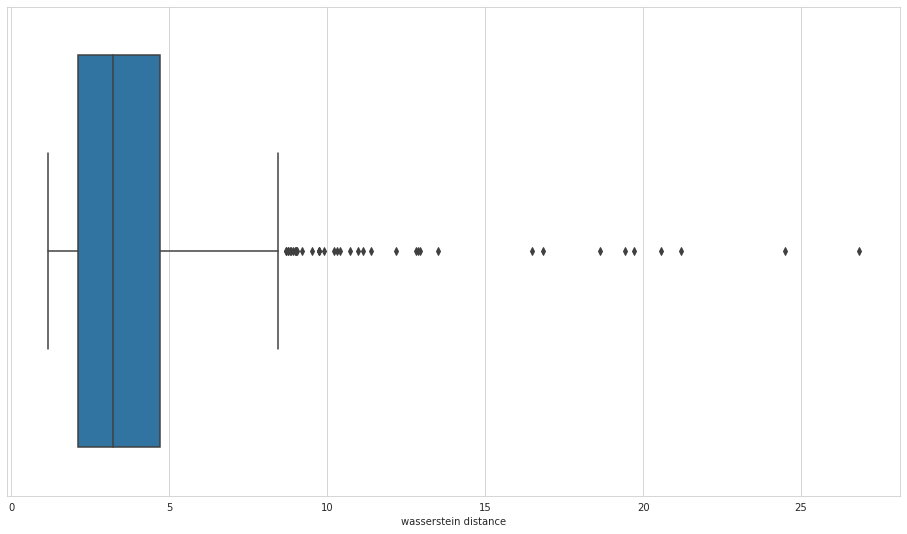

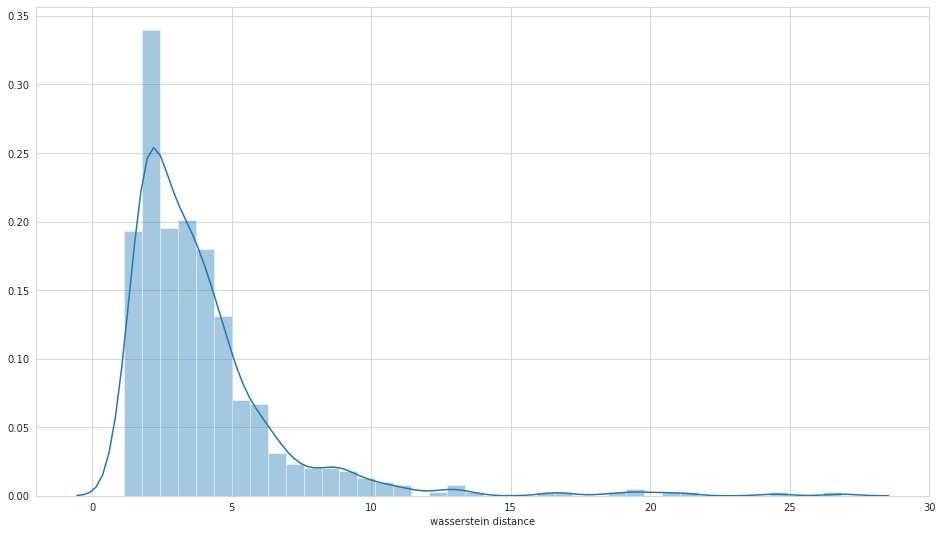

In [25]:
sns.boxplot(x="wasserstein distance", data=test_results_df)
plt.show()
sns.distplot(test_results_df["wasserstein distance"], bins=40)
plt.show()

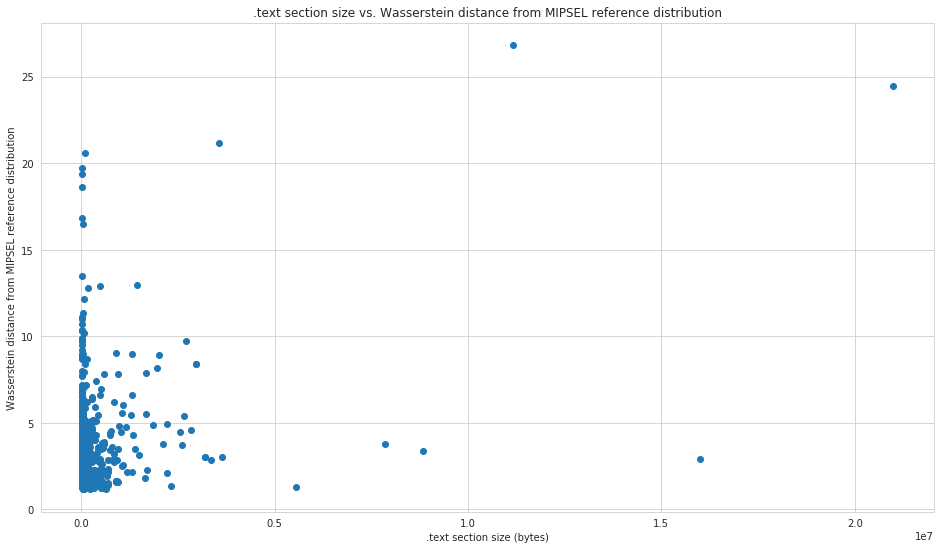

In [26]:
plt.scatter(test_results_df["size"], test_results_df["wasserstein distance"])
plt.xlabel(".text section size (bytes)")
plt.ylabel("Wasserstein distance from MIPSEL reference distribution")
plt.title(".text section size vs. Wasserstein distance from MIPSEL reference distribution")
plt.show()

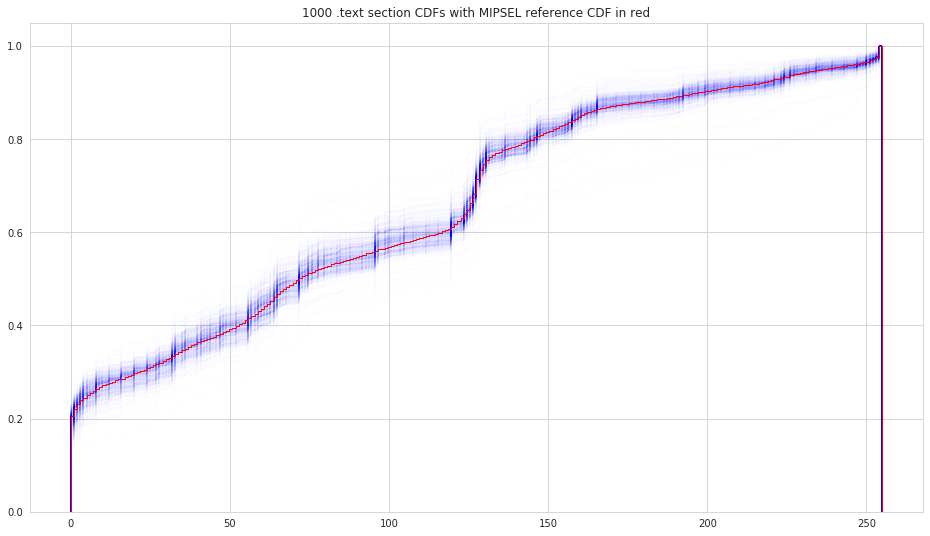

In [33]:
for code in test_code_dict.values():
    plot_sample(code)
    
sns.distplot(median, # reference distribution
             norm_hist=True,     
             kde=False,
             hist_kws={'histtype':'step', 'cumulative': True, 'linewidth':1, 'alpha':1},
             kde_kws={'cumulative': True},
             bins=256,                      
             color="red")

plt.title("1000 .text section CDFs with MIPSEL reference CDF in red")
plt.show()

In [28]:
# export reference distribution
with open("PowerPC_reference", "wb") as f:
    pickle.dump(median, f)